In [1]:
%run ../../_setup.py

from xarray import open_dataset
from netCDF4 import Dataset
import numpy as np
from scipy.interpolate import griddata, interp1d

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

import cmocean as cmo
import string

In [2]:
savefig = False

fs_small=12
fs_large = 14
plt.rc('xtick',labelsize=fs_small)
plt.rc('ytick',labelsize=fs_small)
plt.rc('text', usetex=True)

In [3]:
# load ctd and teos data from SS9802 voyage
input_file_ss98 = os.path.join(datadir, 'ss9802', 'processed', 'ctd', 'ss9802_ctd_gsw.nc')
ctd = Dataset(input_file_ss98)

input_file_gem = os.path.join(datadir, 'ss9802', 'processed', 'ctd', 'ss9802_ctd_gem.nc')
gem = Dataset(input_file_gem)

# load ctd and teos data from AU9706 voyage
input_file_sr3 = os.path.join(datadir, 'au9706', 'processed', 'au9706_ctd_teos10.nc')
sr3 = open_dataset(input_file_sr3)
sr3_teos = open_dataset(input_file_sr3, group='TEOS10')

In [4]:
stations = [2, 18, 19, 21, 23, 40, 41, 44, 46, 67, 66, 65, 53, 73] #, 67, , 73
istations = [i for i, station in enumerate(sr3['station'][:]) if station in stations]

_, istations_sort = zip(*sorted(zip(sr3['latitude'][istations].data, istations)))
istations_sort = list(istations_sort)

In [5]:
# find indices for pressure levels in CTD prodiles
pressure_levels = {}
for ip, pres in enumerate(sr3['pressure'].data):
    pressure_levels[pres] = ip

# define reference and interest level 
# p_ref = 1494
p_int = 2

# get dynamic height contours
D = np.array([sr3_teos['deltaD'][profile, pressure_levels[p_int]] / 
              sr3_teos['g'][profile, pressure_levels[p_int]]
              for profile in range(sr3['station'].size)])

# get dynamic height contours
D_gem = np.array([ctd['deltaD'][profile, pressure_levels[p_int]] / 
              ctd['g'][profile, pressure_levels[p_int]]
              for profile in range(ctd.dimensions['profile'].size)])

# watermass definitions
# Katsumata, Sloyan, Masuda, 2013, Diapycnal and Isopycnal Transports in the Southern Ocean Estimated by a Box Inverse Model
# Orsi, On the total input of Antarctic Waters to the deep ocean: A preliminary estimate from chlorofluorocarbon measurements
watermass = {
    'SAMW': ((26.8, 27.0), -46.25, 450),
    'AAIW': ((27.0, 27.7), -46.25, 1100),
    'UCDW': ((27.7, 27.98), -46.25, 1800),
    'LCDW': ((27.98, 28.27), -54.1, 1700)
}
density_levels = np.unique([value[0] for value in watermass.values()])

/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Warning: converting a masked element to nan.


In [6]:
lati = np.linspace(np.nanmin(sr3['latitude'][istations]), np.nanmax(sr3['latitude'][istations]))

# SR3: interpolate dynamic height on latitudinal grid
mask = np.isnan(D[istations])
f = interp1d(sr3['latitude'][istations][~mask], D[istations][~mask], bounds_error='extrapolate')
Di = f(lati)

latint = np.linspace(-48, -52.5)
Dint = f(latint)
Dmin = 1.2
Dmax = 1.7
imin = (np.abs(Dint - Dmin)).argmin()
imax = (np.abs(Dint - Dmax)).argmin()

# SR3: interpolate gamman on latitudinal grid
pp, ltlt = np.meshgrid(sr3['pressure'], sr3['latitude'][istations_sort])
latgrd, pgrd = np.meshgrid(lati, sr3['pressure'])

gamman = sr3_teos['gamman'][istations_sort].to_masked_array()
mask = gamman.mask
points = list(zip(ltlt[~mask].flatten(), pp[~mask].flatten()))
values = gamman[~mask].flatten()
gammangrd = griddata(points, values, (latgrd, pgrd), method='linear')

# SS9802
nans = np.isnan(D_gem)
nans[0:2] = True

pp, DD = np.meshgrid(ctd['p'], D_gem[~nans])
Dgrd, pgrd_gem = np.meshgrid(np.linspace(np.nanmin(D_gem), np.nanmax(D_gem)), ctd['p'][:])

gem_ref = {}
for var in ['CT', 'SA', 'gamman']:
    mask = gem[var][~nans].mask
    points = list(zip(DD[~mask].flatten(), pp[~mask].flatten()))
    values = gem[var][~nans][~mask].flatten()
    gem_ref[var] = griddata(points, values, (Dgrd, pgrd_gem), method='linear')

CTi = np.linspace(np.nanmin(ctd['CT']), np.nanmax(ctd['CT']))
SAi = np.linspace(np.nanmin(ctd['SA']), np.nanmax(ctd['SA']))
SAgrd, ptgrd = np.meshgrid(SAi, CTi)
mask = gem['gamman'][~nans].mask

points = list(zip(gem['SA'][~nans][~mask], gem['CT'][~nans][~mask]))
values = gem['gamman'][~nans][~mask]
gammangrd_gem = griddata(points, values, (SAgrd, ptgrd), method='linear')



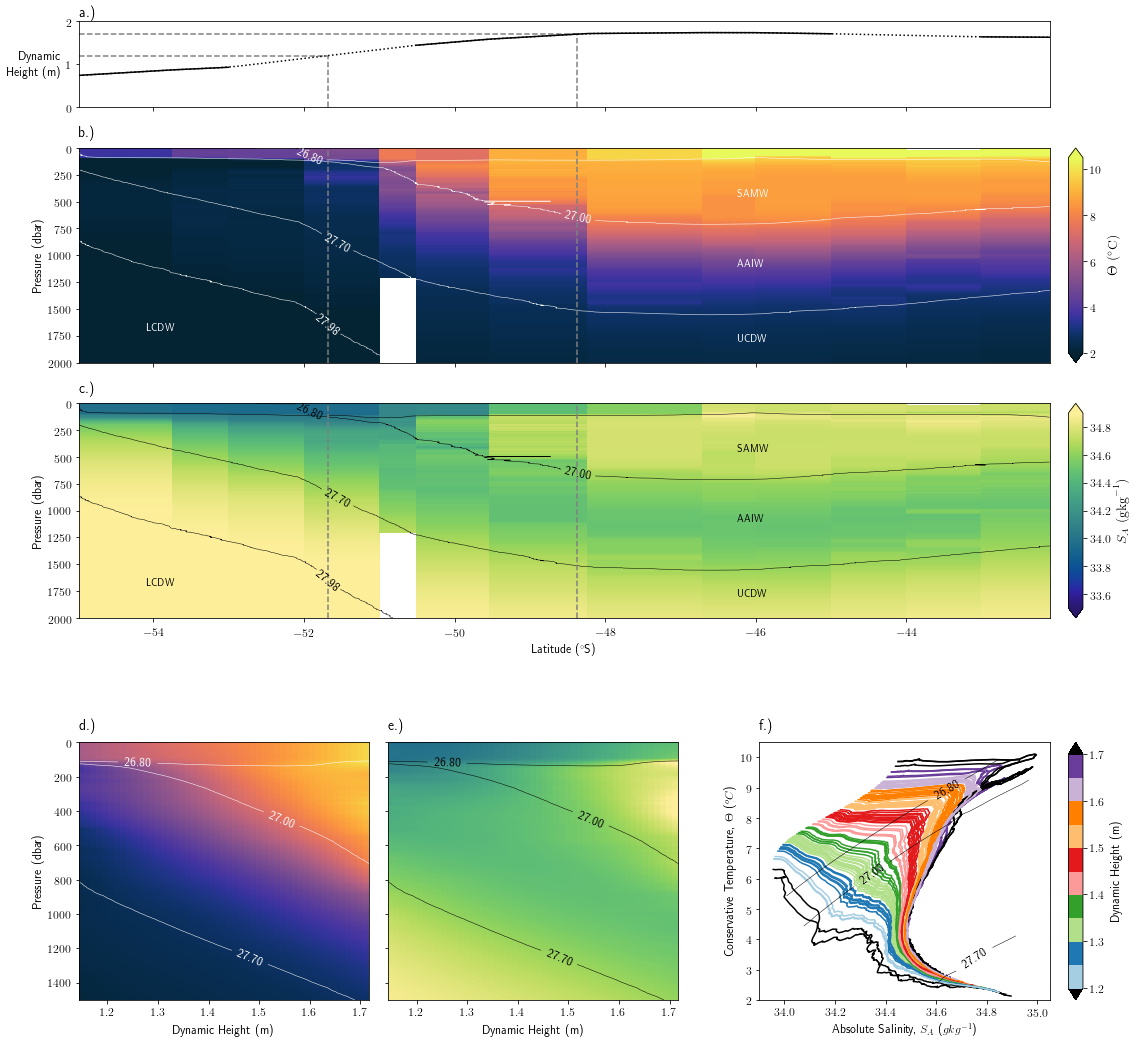

In [7]:
props = {'CT': [cmo.cm.thermal, 'w', (2, 10.5), r'$\Theta \ (^\circ \textrm{C})$', r'Conservative Temperature, $\Theta$ ($^o C$)'], 
         'SA': [cmo.cm.haline, 'k', (33.5, 34.9), r'$S_A \ (\textrm{gkg}^{-1})$', r'Absolute Salinity, $S_A$ ($gkg^{-1}$)']}


fig = plt.figure(figsize=(18, 18))#, constrained_layout=True)
# fig.tight_layout()
gs = gridspec.GridSpec(5, 5, height_ratios=[2, 5, 5, 1, 6], width_ratios = [20, 20, 3, 20, 1])

latmin = min(sr3['latitude'][istations])
latmax = max(sr3['latitude'][istations])

# a.) Dynamic Height 
ax = fig.add_subplot(gs[0, :-1]) # , sharex=fig.axes[0]
ax.plot(lati, Di, 'k', linestyle='dotted')
ax.plot(sr3['latitude'][istations_sort], D[istations_sort], 'k')
ax.vlines(latint[[imin, imax]], 0, [Dmin, Dmax], linestyle='dashed', color='gray')
ax.hlines([Dmin, Dmax], latmin, latint[[imin, imax]], linestyle='dashed', color='gray')
ax.set_xlim([latmin, latmax])
ax.set_ylim([0, 2])
ax.set_yticks([0, 1, 2])
ax.set_ylabel('Dynamic\nHeight (m)', fontsize=fs_small, rotation='horizontal', ha='right', va='center')
# plt.setp(ax.get_xticklabels(), visible=False)

for i, var in enumerate(props.keys()):
    ax = fig.add_subplot(gs[i + 1, :-1])
    
    # plot temp, sal of sr3
    pcol = ax.pcolormesh(sr3['latitude'][istations_sort], sr3['pressure'][:], sr3_teos[var][istations_sort,:].T, 
                         cmap=props[var][0], vmin=props[var][2][0], vmax=props[var][2][1])

    # plot neutral density contours
    cont = ax.contour(latgrd, pgrd, gammangrd, 
                      density_levels, colors=props[var][1], linewidths=0.5)
    for wm in watermass:
        ax.text(watermass[wm][1], watermass[wm][2], wm, color=props[var][1])
    
    ax.set_xlim([latmin, latmax])
    ax.set_ylim([0, 2000])
    ax.invert_yaxis()

    cax = fig.add_subplot(gs[i+1, -1])
    cbar = fig.colorbar(pcol, cax, extend='both')
    cbar.ax.set_ylabel(props[var][3], fontsize=fs_large)

    if i != 2:
        plt.setp(fig.axes[i].get_xticklabels(), visible=False)
    
    ax.clabel(cont, inline=1, fontsize=fs_small, fmt='%.2f')
    ax.set_ylabel('Pressure (dbar)', fontsize=fs_small)

    ax.axvline(x=latint[imin], linestyle='dashed', color='gray')
    ax.axvline(x=latint[imax], linestyle='dashed', color='gray')
ax.set_xlabel(r'Latitude ($^\circ$S)', fontsize=fs_small)

# d.) and e.) GEM reference fields
for i, var in enumerate(props.keys()):
    ax = fig.add_subplot(gs[-1, i])
    ax.set_ylim([0, 1500])
    ax.invert_yaxis()

    pcol = ax.pcolormesh(Dgrd, pgrd_gem, gem_ref[var], 
                     cmap=props[var][0], vmin=props[var][2][0], vmax=props[var][2][1])
    cont = ax.contour(Dgrd, pgrd_gem, gem_ref['gamman'], 
                      density_levels, colors=props[var][1], linewidths=0.5)
    ax.clabel(cont, fontsize=fs_small, fmt='%.2f')
    ax.set_xlabel('Dynamic Height (m)', fontsize=fs_small)
    if i == 0:
        ax.set_ylabel('Pressure (dbar)', fontsize=fs_small)
plt.setp(ax.get_yticklabels(), visible=False)

# f.) T-S diagram
ncolors = 10
bounds = np.linspace(1.2, 1.7, ncolors+1)
colors = plt.cm.Paired(np.linspace(0, 1, 12))
cmap = mcolors.ListedColormap(colors[:-2], "")
cmap.set_under('k')
cmap.set_over('k')
norm = mcolors.BoundaryNorm(bounds, ncolors=ncolors)

ax = fig.add_subplot(gs[4, 3:-1])
# fig, ax=plt.subplots()
for ist in range(2, len(ctd['station'])):
    ax.plot(gem['SA'][ist], gem['CT'][ist], color=cmap(norm(D_gem[ist])))

cont = ax.contour(SAi, CTi, gammangrd_gem, 
                  density_levels, colors='k', zorder=1000, linewidths=0.5)
ax.clabel(cont, inline=1, fontsize=fs_small, fmt='%.2f')
    
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(bounds)
cax = fig.add_subplot(gs[4, -1])
cbar = fig.colorbar(sm, cax, extend='both')
cbar.ax.set_ylabel('Dynamic Height (m)', fontsize=fs_small)

ax.set_ylim([2, 10.5])
ax.set_xlim([33.9, 35.05])
ax.set_ylabel(props['CT'][4], fontsize=fs_small)
ax.set_xlabel(props['SA'][4], fontsize=fs_small)

# spacing and numbering
fig.subplots_adjust(wspace=0.1, hspace=0.25)
ax = fig.get_axes()
for iax, num in zip([0, 1, 2, 3, 4, 5], [0, 1, 3, 5, 6, 7, 0]):
    ax[num].text(0, 1.05, string.ascii_lowercase[iax] + '.)', transform=ax[num].transAxes, size=fs_large, weight='bold')


In [8]:
if savefig:
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        transparent = True if extension == '.png' else False
        fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', '02_reference-field' + extension), 
                    transparent=transparent)